# A python based solution to the BVP

Symmetric instability leads to the generation of overturning cells which can be described by a streamfunction with the equation $\psi(x, z, t) = \sum_m \hat{\psi}(x) e^{i(mz -\omega t)}$. During the linear phase of its development its evolution is governed by the following boundary value problem

$$-\frac{N^2 }{m^2}\, \frac{d^2\hat{\psi}}{dx^2} + f \zeta \hat{\psi} = \hat{\omega}^2 \hat{\psi}\,$$

where $\hat{\omega} = \omega + i A_r m^2$ is an eigenvalue of the equation and the eigenfunction $\hat{\psi}(x)$ gives the horizontal part of the overturning streamfunction.

To solve the problem we discretise the $x$ coordinate which allows us to write a matrix representation of the left hand side of the equation. The matrix acts on a vector representation of $\hat{\psi}$ to give eigenvalues and eigenfunctions which can be easily found using standard numerical linear algebra routines.

## Imports

In [12]:
import numpy as np
import scipy
from scipy.sparse.linalg import eigs
import scipy.sparse as sps
from scipy.optimize import minimize_scalar
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cmocean
import cmocean.cm as cmo
from pathlib import Path

In [14]:
base_path = Path('/work/n01/n01/fwg/nbc-proj')
figure_path = base_path / 'figures'

Check the version numbers. The versions I used are listed in the `environment.yml` file

In [2]:
print(np.__version__)
print(scipy.__version__)
print(matplotlib.__version__)
print(xr.__version__)
print(cmocean.__version__)

1.21.5
1.8.0
3.4.3
2022.3.0
2.0


## Parameters of the problem

Below we set parameters relating to the domain size (including grid spacing) and the flow itself. We also create a matrix representation of the $f\zeta$ and $\frac{d^2}{dx^2}$ operators.

When running this notebook I reccomend increasing the grid-spacing (`dx`) to something larger ($\sim$`2e3` should still give ok results). The value of `1e2` was used here for producing publication quality figures and is overkill even for that.

If you want to play around with different vorticity profiles this can be done by redefining `zeta` in the below code to return the absolute vorticity profile you fancy.

The analysis can be performed in either hydrostatic mode (as is done in the paper) or non-hydrostatic mode, in which a term in $\hat{\omega}^2 d^2_{xx} \hat{\psi} / m^2$ is added on the left hand side of the above equation.

In [3]:
hydrostatic = False

Lx = 400e3  # Domain width in m
dx = 1e3  # Grid spacing in m 
nx = int(Lx / dx)  # Number of grid points
x = np.arange(0, nx * dx, dx)  # x coordinates in m

N2 = 2.5e-5  # Buoyancy frequency (squared) in s^{-2}
f = 1.01e-5  # Planetary vorticity in s^{-1}
A_r = 4e-4  # Viscosity in m^{2} s^{-1}

x_mid = 40e3  # Mid point of the jet in m
delta_b = 30e3  # Width of the jet in m
V_0 = 0.87  # Velocity of the jet in m/s


def zeta(x):
    """ returns the absolute vorticity at x in s^{-1}
    """
    rel_vort = - 2 * V_0 / delta_b * np.tanh((x - x_mid) / delta_b) / np.square(np.cosh((x - x_mid) / delta_b))
    return rel_vort + f


x_vorticity_minima = minimize_scalar(zeta, bounds=[0, Lx], method='bounded', options={'xatol': dx / 10}).x  # Gives x at the vorticity minima

# Create a matrix representation of the curvature operator
diagonals = np.array([1, -2, 1]) / np.square(dx)
d2_dx2 = sps.diags(diagonals, offsets=[-1, 0, 1], shape=(nx, nx))

# Create an array representation of the f * zeta operator
f_zeta_arr = f * zeta(x) 
f_zeta = sps.dia_matrix(f_zeta_arr * np.identity(nx))

## Solve the problem
We now solve the eignvalue problem at predefined values of $\lambda$ and $A_r$ (set in the first two lines). Eigenvalues and eigenfunctions are stored for each value of $\lambda$ considered.

In [4]:
# Create an array of vertical wavelengths at which to solve the eigenvalue problem.
# Increasing the number of lambda points will increase the run time
lambda_arr = np.logspace(0, 2.5, num=500)

# Create an array of vertical viscosities at which to calculate the instabilities growth rate
# Increasing the number of viscosity points will not significantly alter the run time
viscosity_arr = np.logspace(np.log10(5e-7), -2, num=500)

def calculate_eigenvalue(lambda_val):
    """ Calculates the eigenvalue of the LSA equation (i.e. \hat{\omega}^2)
    
    Arguments:
    lambda_val (float)--> Value of lambda at which to solve the problem
    
    Returns:
    eigan_val (tuple) --> first element is the eigenvalue, second the eigenfunction
    """
    m = 2 * np.pi / lambda_val
    m2 = np.square(m)
    eigen_operator = -N2 / m2 * d2_dx2 + f_zeta
    
    if hydrostatic:
        eigen_val = eigs(eigen_operator, k=1, which='SR', return_eigenvectors=True)
    else:
        generalised_M =  sps.eye(nx) - d2_dx2 / m2  # Identiy - d2/dx2
        eigen_val = eigs(eigen_operator, k=1, M=generalised_M, which='SR', return_eigenvectors=True)
        
    return eigen_val

# Create empty arrays in which to store the eigenvalues and the eigenfunctions
eigen_value_arr = np.empty_like(lambda_arr, dtype='complex')
psi_arr = np.empty((lambda_arr.size, x.size, 1), dtype='complex')

# Looping over the different wavelengths calculate the eigenvalues and eigenfunctions of the
# least stable mode.
for ii in range(len(lambda_arr)):
    eigen_value_arr[ii], psi_arr[ii] = calculate_eigenvalue(lambda_arr[ii])

psi_arr = psi_arr.squeeze().real  # Get rid of the extra dimension of the eigenfunction array. Get rid of the complex part (should be zero anyway)

Here we continue the analysis and store the output in an xarray output which makes many calculations easier than if we stuck with the numpy arrays previously obtained. We perform some further calculation such as calculating the growth rate from the raw eigenvalues, calculating the least stable wavelengths at each value of $A_r$ etc.

In [5]:
# Analysis is made easier by converting the eigenfunctions and eigenvalues into xarray objects.
ds = xr.Dataset(coords={'lambda': lambda_arr, 'viscosity': viscosity_arr, 'lon': x})
ds['eigen_value'] = ds['lambda'].copy(data=eigen_value_arr)
ds['psi_unnormalised'] = (('lambda', 'lon'), psi_arr)


ds['m'] = 2 * np.pi / ds['lambda']
ds['m2'] = np.square(ds['m'])


# Calculate the growth rate from the eigenvalues
ds['omega_hat'] = ds['lambda'].copy(data=np.lib.scimath.sqrt(ds['eigen_value']))
ds['omega'] = ds['omega_hat'] - 1j * ds['viscosity'] * ds['m2']
ds['sigma'] = ds['omega'].where(ds['omega'].imag >= 0).imag.transpose('viscosity', 'lambda')  # Selects sigma >= 0 at the same time
ds['sigma_normalised'] = ds['sigma'] / f


# Calculate the wavelength of the least stable vertical mode as a function of the viscosity
ds['lambda_unstable'] = ds['sigma'].idxmax(dim='lambda')
ds['sigma_unstable'] = ds['sigma'].max('lambda')
ds['time_scale_days'] = 1 / (ds['sigma_unstable'] * 24 * 60 * 60)

# Apply one of two normalisations to the streamfunction to enable comparisons
ds['psi_sign_corrected'] = np.sign(ds['psi_unnormalised'].sel({'lon': x_vorticity_minima}, method='nearest')) * ds['psi_unnormalised']  # Correct the sign
ds['psi_norm_area'] = ds['psi_sign_corrected'] / ds['psi_sign_corrected'].sum('lon')  # Gives the normalised streamfunction
ds['psi_norm_max'] = ds['psi_sign_corrected'] / ds['psi_sign_corrected'].sel({'lon': x_vorticity_minima}, method='nearest')


ds

<xarray.Dataset>
Dimensions:             (lambda: 500, viscosity: 500, lon: 400)
Coordinates:
  * lambda              (lambda) float64 1.0 1.012 1.023 ... 309.0 312.6 316.2
  * viscosity           (viscosity) float64 5e-07 5.1e-07 ... 0.009803 0.01
  * lon                 (lon) float64 0.0 1e+03 2e+03 ... 3.98e+05 3.99e+05
Data variables: (12/14)
    eigen_value         (lambda) complex128 (-1.2293501492337282e-10+0j) ... ...
    psi_unnormalised    (lambda, lon) float64 -1.249e-17 ... -6.922e-08
    m                   (lambda) float64 6.283 6.211 6.14 ... 0.0201 0.01987
    m2                  (lambda) float64 39.48 38.58 37.7 ... 0.000404 0.0003948
    omega_hat           (lambda) complex128 1.1087606365820028e-05j ... (3.40...
    omega               (lambda, viscosity) complex128 -8.651602436358687e-06...
    ...                  ...
    lambda_unstable     (viscosity) float64 11.54 11.67 11.67 ... nan nan nan
    sigma_unstable      (viscosity) float64 1.067e-05 1.067e-05 ... nan nan
    time_scale_days     (viscosity) float64 1.085 1.085 1.085 ... nan nan nan
    psi_sign_corrected  (lambda, lon) float64 1.249e-17 -6.228e-19 ... 6.922e-08
    psi_norm_area       (lambda, lon) float64 6.598e-18 -3.289e-19 ... 6.847e-09
    psi_norm_max        (lambda, lon) float64 1.688e-17 -8.416e-19 ... 4.714e-07

Calculate the time scale and wavelength for a viscosity of `A_r` and `1e-6`

In [6]:
print('Times scale:', ds['time_scale_days'].sel({'viscosity': A_r}, method='nearest').values, 'days')
print('Wavelength:', ds['lambda_unstable'].sel({'viscosity': A_r}, method='nearest').values, 'metres')

Times scale: 1.6798838554828706 days
Wavelength: 104.48118175985638 metres


In [7]:
print('Times scale:', ds['time_scale_days'].sel({'viscosity': 1e-6}, method='nearest').values, 'days')
print('Wavelength:', ds['lambda_unstable'].sel({'viscosity': 1e-6}, method='nearest').values, 'metres')

Times scale: 1.0964950671282165 days
Wavelength: 14.531975242368961 metres


## Visualise the output

In [59]:
from matplotlib import font_manager as fm
fpath = Path('/home/n01/n01/fwg/.local/share/fonts/PTSans-Regular.ttf')
font_prop = fm.FontProperties(fname=fpath)

In [60]:
# Set plotting defaults to make the plots look nice
#plt.rc('font', family='serif', size='7')
plt.rc('xtick', labelsize='5')
plt.rc('ytick', labelsize='5')
plt.rc('text', usetex=False)
plt.rcParams['axes.titlesize'] = 7

plt.rcParams['font.family'] = font_prop.get_family()
plt.rcParams['font.sans-serif'] = [font_prop.get_name()]

Plot the dispersion relation

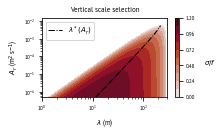

In [61]:
fig, ax = plt.subplots(figsize=[3.1, 1.9])

cax = ax.contourf(ds['lambda'], ds['viscosity'], ds['sigma_normalised'], levels=np.linspace(0, 1.2, 11), cmap=cmo.amp)
cb = plt.colorbar(cax)
cb.set_label('$\sigma / f$', rotation=0, labelpad=15)

ax.plot(ds['lambda_unstable'], ds['viscosity'], '-.k', lw=1, label='$\\lambda^*(A_r)$')
ax.legend(loc='upper left')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 300)
ax.set_ylim(5e-7, 1.5e-2)

ax.set_xlabel('$\lambda$ (m)')
ax.set_ylabel('$A_r$ (m$^2\,$s$^{-1}$)')
ax.set_title('Vertical scale selection')

fig.tight_layout()
fig.savefig(figure_path / 'vertical_scale_selection.pdf')
plt.show()

Plot the two dimensional streamfunction for a viscosity of `A_r`

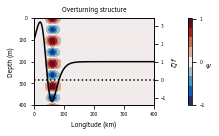

In [62]:
# Define z and calculate psi(x, z)
ds['z'] = np.linspace(-400, -0, num=100)
lambda_unstable = ds['lambda_unstable'].sel({'viscosity': A_r}, method='nearest')
psi2D = np.cos(2 * np.pi / lambda_unstable * ds['z']) * ds['psi_norm_max'].sel({'lambda': lambda_unstable}, method='nearest')

# Plotting 
clim = 1.01

fig, ax = plt.subplots(figsize=[3.1, 1.9])
cax = ax.contourf(ds['lon'] * 1e-3, -ds['z'], psi2D, cmap=cmo.balance, levels = np.linspace(-clim, clim, 10), vmin=-clim, vmax=clim)
cb = plt.colorbar(cax, ax=ax, ticks=np.linspace(-2, 2, 5), pad=0.19)
cb.set_label('$\psi$', rotation=0)

ax.invert_yaxis()
ax.set_xlabel('Longitude (km)')
ax.set_ylabel('Depth (m)')
ax.set_title('Overturning structure')
ax.set_xticks(np.linspace(0, 400, 9))

ax2 = ax.twinx()
ax2.plot(x * 1e-3, zeta(ds['lon']) / f, 'k', lw=1.5)
ax2.set_ylabel('$\zeta / f$')
ax2.axhline(0, c='k', ls=':')

ax.set_xlim((0, 400))
ax.set_xticks([0, 100, 200, 300, 400])
ax.set_yticks([0, 100, 200, 300, 400])

fig.tight_layout()
fig.savefig(figure_path / 'overturning_structure.pdf')
plt.show()

Plot $\hat{\psi}(x)$ for different wavelengths. This is not contained in the paper. Note this may take a while to run.

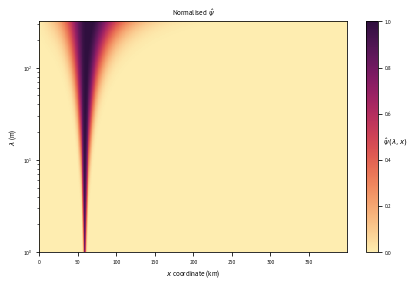

In [63]:
fig, ax = plt.subplots()

cax = ax.pcolor(ds['lon'] * 1e-3, ds['lambda'], ds['psi_norm_max'], shading='auto', cmap=cmo.matter, vmin=0, vmax=1)
ax.set_ylabel('$\lambda$ (m)')
ax.set_xlabel('$x$ coordinate (km)')

cb = fig.colorbar(cax)
cb.set_label('$\hat{\psi}\,(\lambda, x)$', rotation=0, loc='center')

ax.set_title('Normalised $\hat{\psi}$')
ax.set_yscale('log')
fig.tight_layout()